In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt




class ExtractExudates:
    
    jpegImg = 0
    grayImg = 0
    curImg = 0
    def __init__(self,img): 
        self.img = img
        

    def setImage(self,img):
        self.jpegImg = img
        self.curImg = np.array(img)    ##Convert jpegFile to numpy array (Required for CV2)

    def getImage(self):
        return self.curImg
        
    def greenComp(self):
    ###Extracting Green Component
        gcImg = self.curImg[:,:,1]
        self.curImg = gcImg

    def applyCLAHE(self):
    #Applying Contrast Limited Adaptive Histogram Equalization (CLAHE)
        clahe = cv2.createCLAHE()
        clImg = clahe.apply(self.curImg)
        self.curImg = clImg
        
# create a CLAHE object (Arguments are optional).
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#claheImg = clahe.apply(clImg)
#cv2.imwrite('clahe_2.jpg',claheImg)

    def applyDilation(self):
        #Creating Structurig Element
        strEl = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
        #Dilation
        dilateImg = cv2.dilate(self.curImg, strEl)
        self.curImg = dilateImg

    def applyThreshold(self):
        #Thresholding with Complement/Inverse
        retValue, threshImg = cv2.threshold(self.curImg, 220, 220, cv2.THRESH_BINARY)
        self.curImg = threshImg

    def applyMedianFilter(self):
        #Median Filtering
        medianImg = cv2.medianBlur(self.curImg,5)
        self.curImg = medianImg

       
        


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

Using TensorFlow backend.


In [ ]:
import pandas as pd

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/Diabetic Retinopathy/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Diabetic Retinopathy/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

(3112,) (3112,) (550,) (550,)


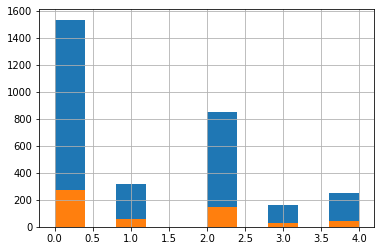

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=0)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

In [ ]:
path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/{df_train['id_code']}.png"
image = cv2.imread(path)


In [ ]:
 ExEd = 0

In [ ]:
p=ExtractExudates("/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/cd54d022e37d.png")


In [ ]:
p.getImage()

0

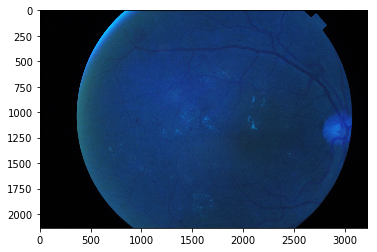

In [ ]:
path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/000c1434d8d7.png"
imd = cv2.imread(path)
plt.imshow(imd,)

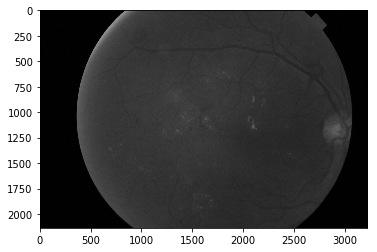

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/000c1434d8d7.png"
imd = cv2.imread(path)   
gray = rgb2gray(imd)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

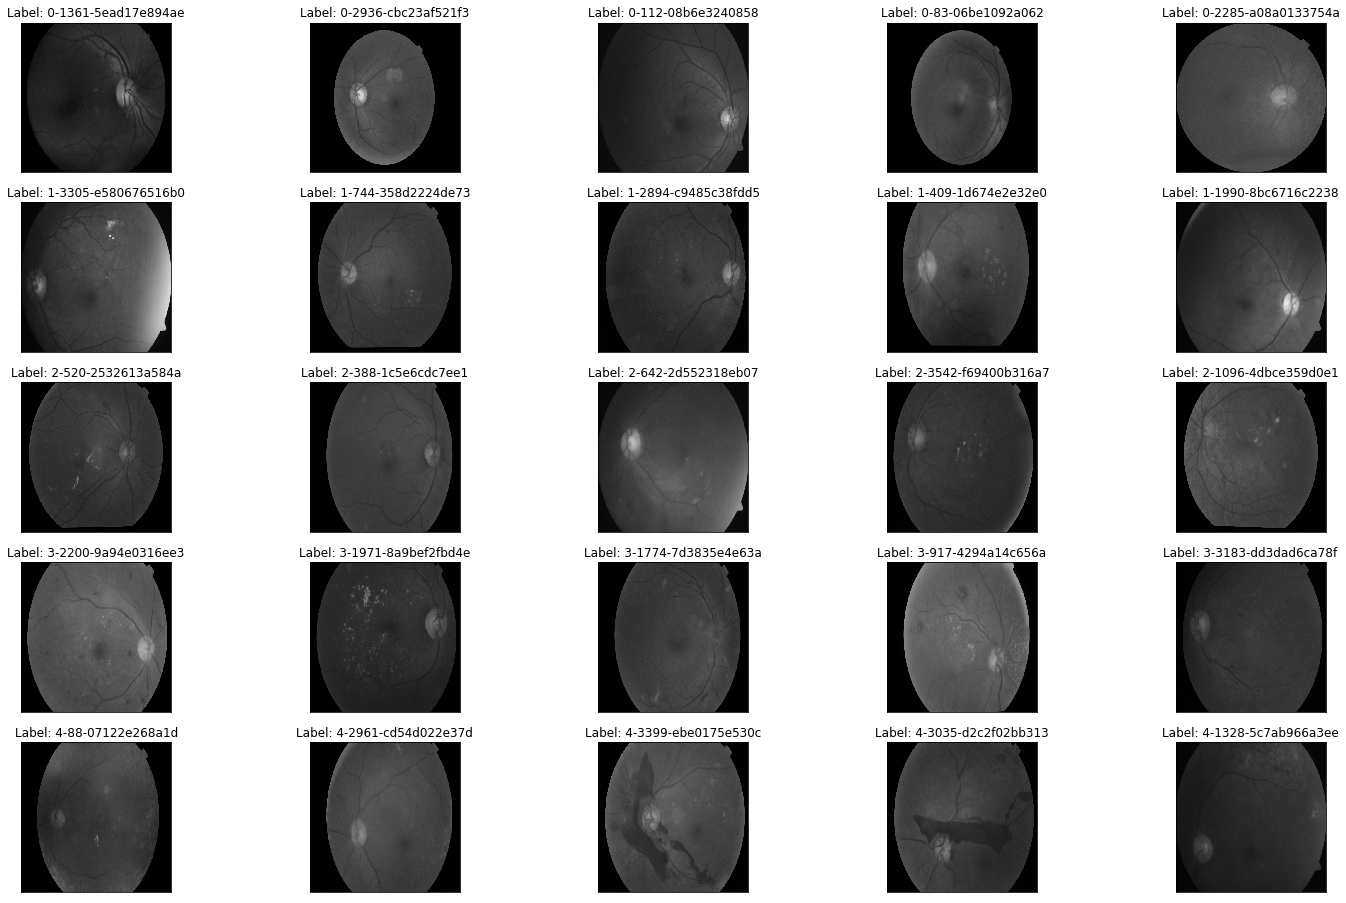

In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = rgb2gray(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
         
        plt.imshow(image,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
def preprocess(images):

		new_images = []

		for i, img in enumerate(images):

			clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(40,40))
			img = clahe.apply(img)

			img = cv2.bilateralFilter(img, -1, 20, 20)

			intensities = medfilt(img, (21, 21))
			intensities = intensities.astype(np.float32)
			intensities_smoothed = cv2.bilateralFilter(intensities, -1, 70, 13)
			width, height = img.shape
			img[0:width, 0:height] = img[0:width, 0:height] + (90) - intensities_smoothed[0:width, 0:height]
			idx = img[:] > 210
			img[idx] = 18

			clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(1,1))
			img = clahe.apply(img)

			new_images.append(img)

		return np.array(new_images)

In [ ]:
import scipy

In [ ]:
import os
import scipy
import tensorflow as tf
import numpy as np

import time
from scipy import misc, ndimage
import random
from scipy.signal import medfilt
import cv2
import math

In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        
       
         
        plt.imshow(image,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
jpegImg = 0
grayImg = 0
curImg = 0

def Imae(img):
    image = rgb2gray(img)
    jpegImg = imga
    curImg = np.array(img)
#     print(curImg)
    gcImg = curImg[:,:,1]
    curImg = gcImg
#     print(curImg)
    image = rgb2gray(image)
    #Applying Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE()
    clImg = clahe.apply(curImg)
    curImg = clImg
    #Creating Structurig Element
    strEl = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
    #Dilation
    dilateImg = cv2.dilate(curImg, strEl)
    curImg = dilateImg
    #Thresholding with Complement/Inverse
    retValue, threshImg = cv2.threshold(curImg, 220, 220, cv2.THRESH_BINARY)
    curImg = threshImg
    #Median Filtering
    medianImg = cv2.medianBlur(curImg,5)
    curImg = medianImg
    plt.imshow(curImg, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

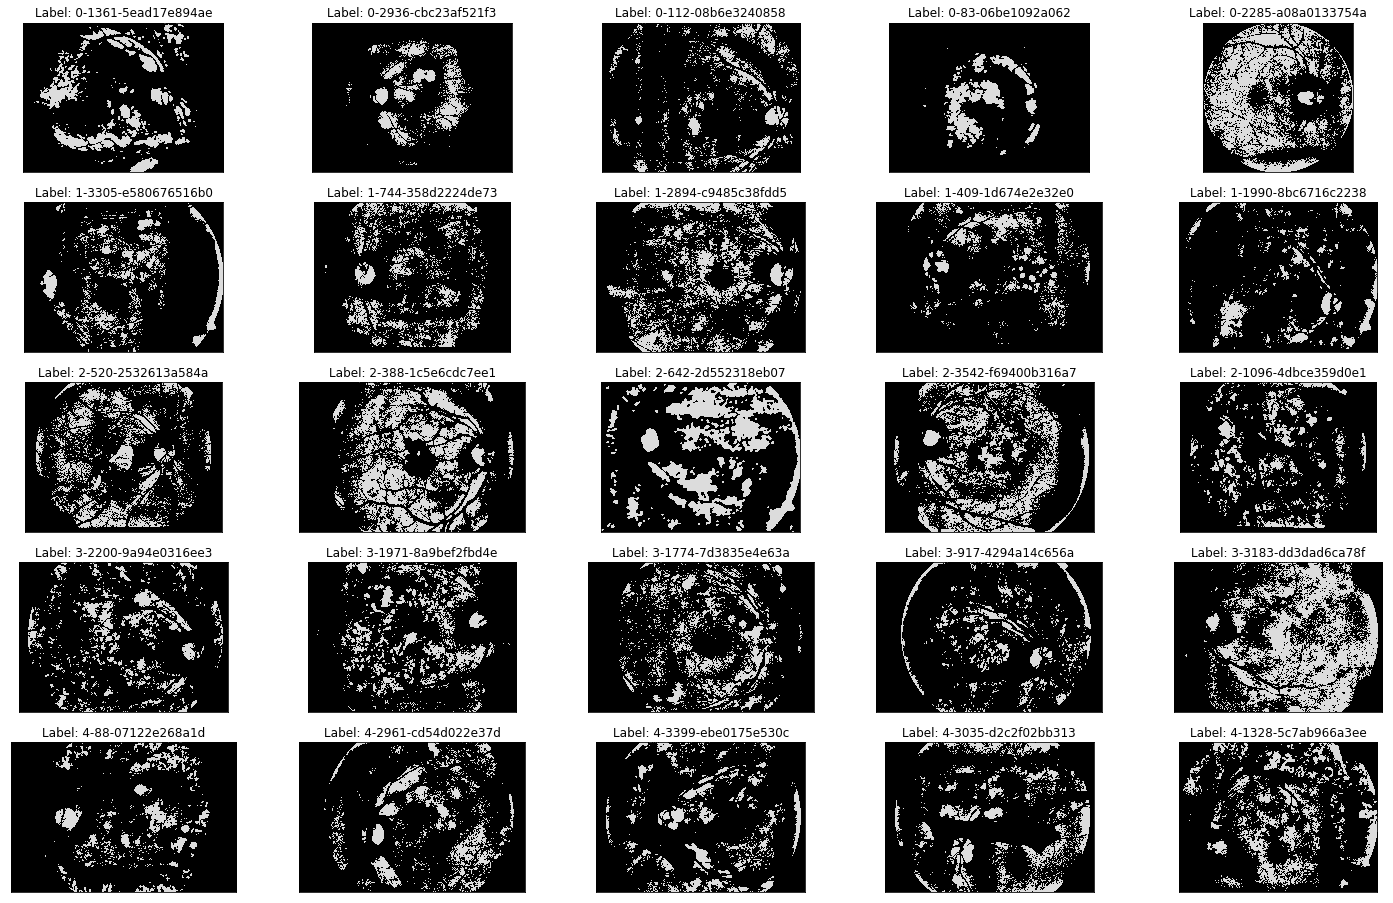

In [ ]:
import numpy as np
import cv2


fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image1 = Imae(image)
       # image = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)
#         image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
         
      
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [ ]:
import numpy as np
import cv2
#from matplotlib import pyplot as plt
from skimage import morphology

class BloodVessels:
    #img = cv2.imread("E:\\Rasheed Files\\Rasheed Data (DONOT DELETE)\\FYP\Dataset\\1\\30_left.jpeg")
    
    jpegImg = 0
    grayImg = 0
    curImg = 0
    
    
    def setImage(self, img):
        self.jpegImg = img
        self.curImg = np.array(img)    ##Convert jpegFile to numpy array (Required for CV2)


    def getImage(self):
        return self.curImg

        
    def greenComp(self):
    ###Extracting Green Component
        gcImg = self.curImg[:,:,1]
        self.curImg = gcImg
    
    
    def histEqualize(self):
        histEqImg = cv2.equalizeHist(self.curImg)
        self.curImg = histEqImg    


    def applyKirschFilter(self):
        gray = self.curImg
        if gray.ndim > 2:
            raise Exception("illegal argument: input must be a single channel image (gray)")
        kernelG1 = np.array([[ 5,  5,  5],
                             [-3,  0, -3],
                             [-3, -3, -3]], dtype=np.float32)
        kernelG2 = np.array([[ 5,  5, -3],
                             [ 5,  0, -3],
                             [-3, -3, -3]], dtype=np.float32)
        kernelG3 = np.array([[ 5, -3, -3],
                             [ 5,  0, -3],
                             [ 5, -3, -3]], dtype=np.float32)
        kernelG4 = np.array([[-3, -3, -3],
                             [ 5,  0, -3],
                             [ 5,  5, -3]], dtype=np.float32)
        kernelG5 = np.array([[-3, -3, -3],
                             [-3,  0, -3],
                             [ 5,  5,  5]], dtype=np.float32)
        kernelG6 = np.array([[-3, -3, -3],
                             [-3,  0,  5],
                             [-3,  5,  5]], dtype=np.float32)
        kernelG7 = np.array([[-3, -3,  5],
                             [-3,  0,  5],
                             [-3, -3,  5]], dtype=np.float32)
        kernelG8 = np.array([[-3,  5,  5],
                             [-3,  0,  5],
                             [-3, -3, -3]], dtype=np.float32)
    
        g1 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG1), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g2 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG2), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g3 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG3), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g4 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG4), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g5 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG5), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g6 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG6), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g7 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG7), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g8 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG8), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        magn = cv2.max(g1, cv2.max(g2, cv2.max(g3, cv2.max(g4, cv2.max(g5, cv2.max(g6, cv2.max(g7, g8)))))))
        self.curImg = magn

    
    def applyThreshold(self):
        ret, threshImg = cv2.threshold(self.curImg,160,180,cv2.THRESH_BINARY_INV)
        self.curImg = threshImg

    
    def cleanSmallObjects(self):
        cleanImg = morphology.remove_small_objects(self.curImg, min_size=130, connectivity=100)
        self.curImg = cleanImg
    
    #cv2.imwrite('Final123.jpg',threshImg)

In [ ]:
jpeImg = 0
graImg = 0
cuImg = 0


def bloodv(img):
   jpeImg = img
   cuImg = np.array(img)
  ###Extracting Green Component
   gImg = cuImg[:,:,1]
   cuImg = gImg
   histEqImg = cv2.equalizeHist(cuImg)
   cuImg = histEqImg    
   gray = cuImg
   if gray.ndim > 2:
        raise Exception("illegal argument: input must be a single channel image (gray)")
        kernelG1 = np.array([[ 5,  5,  5],
                             [-3,  0, -3],
                             [-3, -3, -3]], dtype=np.float32)
        kernelG2 = np.array([[ 5,  5, -3],
                             [ 5,  0, -3],
                             [-3, -3, -3]], dtype=np.float32)
        kernelG3 = np.array([[ 5, -3, -3],
                             [ 5,  0, -3],
                             [ 5, -3, -3]], dtype=np.float32)
        kernelG4 = np.array([[-3, -3, -3],
                             [ 5,  0, -3],
                             [ 5,  5, -3]], dtype=np.float32)
        kernelG5 = np.array([[-3, -3, -3],
                             [-3,  0, -3],
                             [ 5,  5,  5]], dtype=np.float32)
        kernelG6 = np.array([[-3, -3, -3],
                             [-3,  0,  5],
                             [-3,  5,  5]], dtype=np.float32)
        kernelG7 = np.array([[-3, -3,  5],
                             [-3,  0,  5],
                             [-3, -3,  5]], dtype=np.float32)
        kernelG8 = np.array([[-3,  5,  5],
                             [-3,  0,  5],
                             [-3, -3, -3]], dtype=np.float32)
    
        g1 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG1), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g2 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG2), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g3 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG3), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g4 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG4), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g5 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG5), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g6 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG6), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g7 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG7), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g8 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG8), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        magn = cv2.max(g1, cv2.max(g2, cv2.max(g3, cv2.max(g4, cv2.max(g5, cv2.max(g6, cv2.max(g7, g8)))))))
        cuImg = magn
   ret, threshImg = cv2.threshold(cuImg,160,180,cv2.THRESH_BINARY_INV)
   cuImg = threshImg     
   cleanImg = morphology.remove_small_objects(cuImg, min_size=130, connectivity=100)
   cuImg = cleanImg 
   plt.imshow(cuImg,cmap=plt.get_cmap('gray'), vmin=0, vmax=255) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray

        
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        imag = bloodv(image)
        #imag = rgb2gray(imag)
        #image = cv2.resize(imag, (IMG_SIZE, IMG_SIZE))
         
        plt.imshow(image,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )



In [ ]:
def extract_bv(image):
  b,green_fundus,r = cv2.split(image)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  contrast_enhanced_green_fundus = clahe.apply(green_fundus)
  # applying alternate sequential filtering (3 times closing opening)
  r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
  f5 = clahe.apply(f4)

  # removing very small contours through area parameter noise removal
  ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
  mask = np.ones(f5.shape[:2], dtype="uint8") * 255
  im2, contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contours:
    if cv2.contourArea(cnt) <= 200:
      cv2.drawContours(mask, [cnt], -1, 0, -1)			
  im = cv2.bitwise_and(f5, f5, mask=mask)
  ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
  newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

  # removing blobs of microaneurysm & unwanted bigger chunks taking in consideration they are not straight lines like blood
  # vessels and also in an interval of area
  fundus_eroded = cv2.bitwise_not(newfin)
  xmask = np.ones(image.shape[:2], dtype="uint8") * 255
  x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
  for cnt in xcontours:
    shape = "unidentified"
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
    if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
      shape = "circle"	
    else:
      shape = "veins"
    if(shape=="circle"):
      cv2.drawContours(xmask, [cnt], -1, 0, -1)	
	
  finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
  blood_vessels = cv2.bitwise_not(finimage)
  dilated = cv2.erode(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations=1)
  #dilated1 = cv2.dilate(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
  blood_vessels_1 = cv2.bitwise_not(dilated)
  return blood_vessels_1

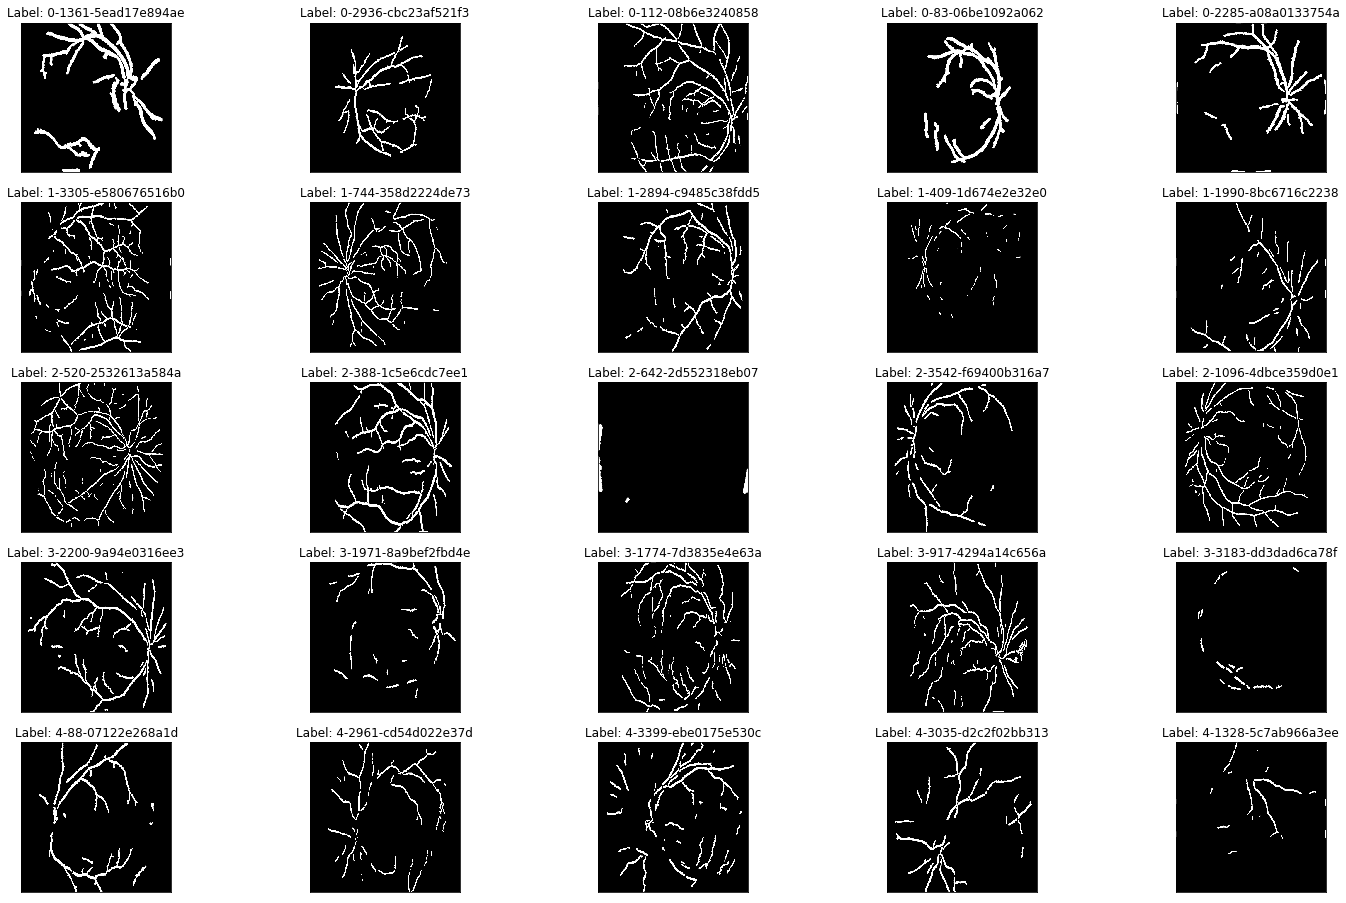

In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        imag = extract_bv(image)
        imag = rgb2gray(imag)
        image = cv2.resize(imag, (IMG_SIZE, IMG_SIZE))
         
        plt.imshow(image,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )
      
      
      
      




In [ ]:
path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/{row['id_code']}.png"
image = cv2.imread(path)
image1 = Imae(image)
plt.imshow(image1)